In [1]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
import numpyro

In [2]:
def signal_model(t, a, m, s):
    return jnp.sum(a * jax.scipy.stats.norm.pdf(t[..., None], m, s), axis = -1)

def snr_to_amplitude(snr, s, sn, t):
    return snr * sn * (2 * jnp.pi**0.5 * s * (t[1] - t[0]))**0.5

def amplitude_to_snr(a, s, sn, t):
    return a / sn / (2 * jnp.pi**0.5 * s * (t[1] - t[0]))**0.5

2024-11-30 16:19:40.070278: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


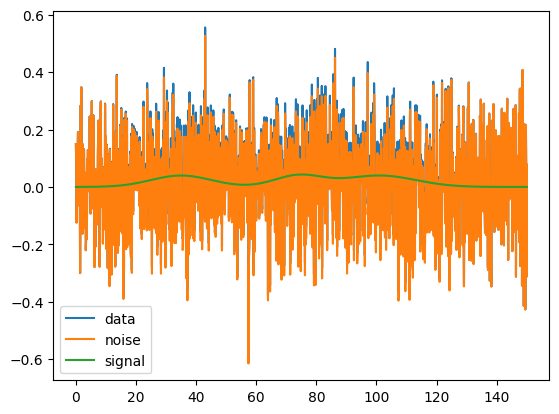

In [3]:
t = jnp.linspace(0, 150, 1501)

a = jnp.array([1, 0.8, 1.2])
m = jnp.array([35, 74, 101])
s = jnp.array([10, 8, 12])

sn = 0.15

snr = amplitude_to_snr(a, s, sn, t)

sort = jnp.argsort(snr)[::-1]
snr = snr[sort]
a = a[sort]
m = m[sort]
s = s[sort]

signal = signal_model(t, a, m, s)
noise = jax.random.normal(jax.random.key(0), t.shape) * sn
data = signal + noise

plt.plot(t, data, label = 'data')
plt.plot(t, noise, label = 'noise')
plt.plot(t, signal, label = 'signal')
plt.legend();

In [4]:
def sample(name, dist, *args, **kwargs):
    prior = numpyro.distributions.Normal()
    z = numpyro.sample(f'_{name}', prior, *args, **kwargs)
    return numpyro.deterministic(name, dist.icdf(prior.cdf(z)))

## fixed dimension HMC

In [5]:
# Reorder x from largest to smallest value while preserving uniform density
# in the allowed region of parameters space.
# See Eq. (5) of https://arxiv.org/abs/1907.11631.

def order(x):
    k = x.size
    i = jnp.arange(k)
    y = jnp.power(1 - x, 1 / (k - i))
    y = jnp.cumprod(y)
    return y

In [6]:
def model():
    with numpyro.plate('n', 3):
        # snr = numpyro.sample('snr', numpyro.distributions.Uniform(0, 10))
        # snr = sample('snr', numpyro.distributions.Uniform(0, 10))
        _snr = numpyro.sample('_snr', numpyro.distributions.Uniform())
        # _snr = sample('_snr', numpyro.distributions.Uniform())
        snr = numpyro.deterministic('snr', order(_snr) * 10)

        m = numpyro.sample('m', numpyro.distributions.Uniform(0, 150))
        # m = sample('m', numpyro.distributions.Uniform(0, 150))
        # _m = numpyro.sample('_m', numpyro.distributions.Uniform())
        # _m = sample('_m', numpyro.distributions.Uniform())
        # m = numpyro.deterministic('m', order(_m) * 150)

        s = numpyro.sample('s', numpyro.distributions.Uniform(5, 20))
        # s = sample('s', numpyro.distributions.Uniform(5, 20))

    a = numpyro.deterministic('a', snr_to_amplitude(snr, s, sn, t))
    signal = signal_model(t, a, m, s)
    noise = (data - signal) / sn
    with numpyro.plate('t', t.size):
        numpyro.sample('noise', numpyro.distributions.Normal(), obs = noise)

In [7]:
nuts = numpyro.infer.NUTS(model, dense_mass = False)
mcmc = numpyro.infer.MCMC(
    nuts,
    num_warmup = 1_000,
    num_samples = 1_000, 
    # thinning = 100,
    num_chains = 100,
    chain_method = 'vectorized',
    progress_bar = True,
)
mcmc.run(jax.random.key(1))
mcmc.print_summary()

sample: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:50<00:00, 39.89it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   _snr[0]      0.71      0.14      0.74      0.50      0.93    498.62      1.07
   _snr[1]      0.42      0.24      0.42      0.00      0.74    450.55      1.08
   _snr[2]      0.59      0.27      0.63      0.19      1.00   1572.85      1.03
      m[0]     72.03     22.18     84.92     37.02     92.55     59.15      3.69
      m[1]     55.83     23.17     42.37     33.28     92.44     61.01      3.21
      m[2]     86.37     42.19     88.14     27.89    150.00   8128.00      1.01
      s[0]     13.70      3.18     13.64      9.01     19.45   1035.91      1.04
      s[1]     12.38      3.51     12.08      6.95     18.63   3005.01      1.02
      s[2]     12.49      4.32     12.45      6.40     19.85  23964.27      1.00

Number of divergences: 0


In [8]:
snrs = mcmc.get_samples()['snr']
aa = mcmc.get_samples()['a']
mm = mcmc.get_samples()['m']
ss = mcmc.get_samples()['s']
snrs.shape

(100000, 3)

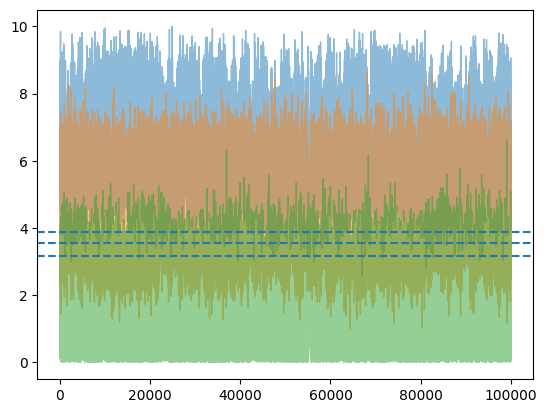

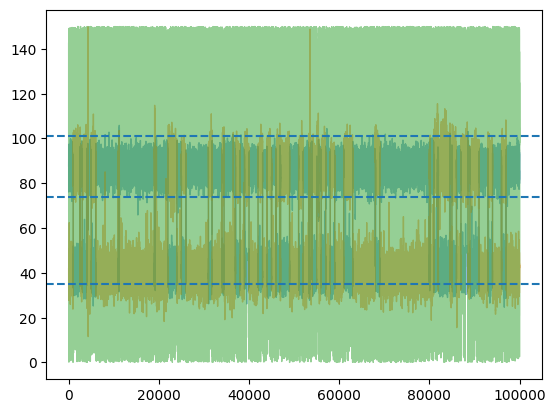

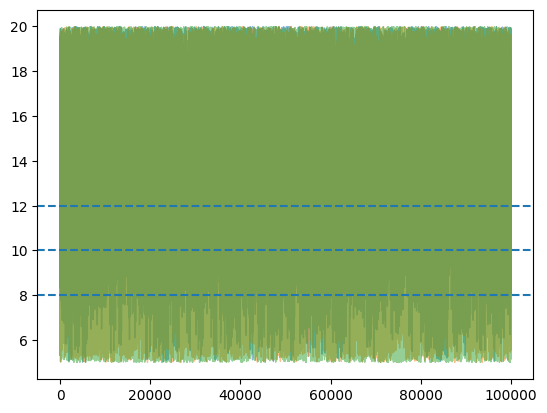

In [9]:
for chains, truths in zip((snrs, mm, ss), (snr, m, s)):
    plt.plot(chains, lw = 1, alpha = 0.5)
    for truth in truths:
        plt.axhline(truth, ls = '--')
    plt.show()

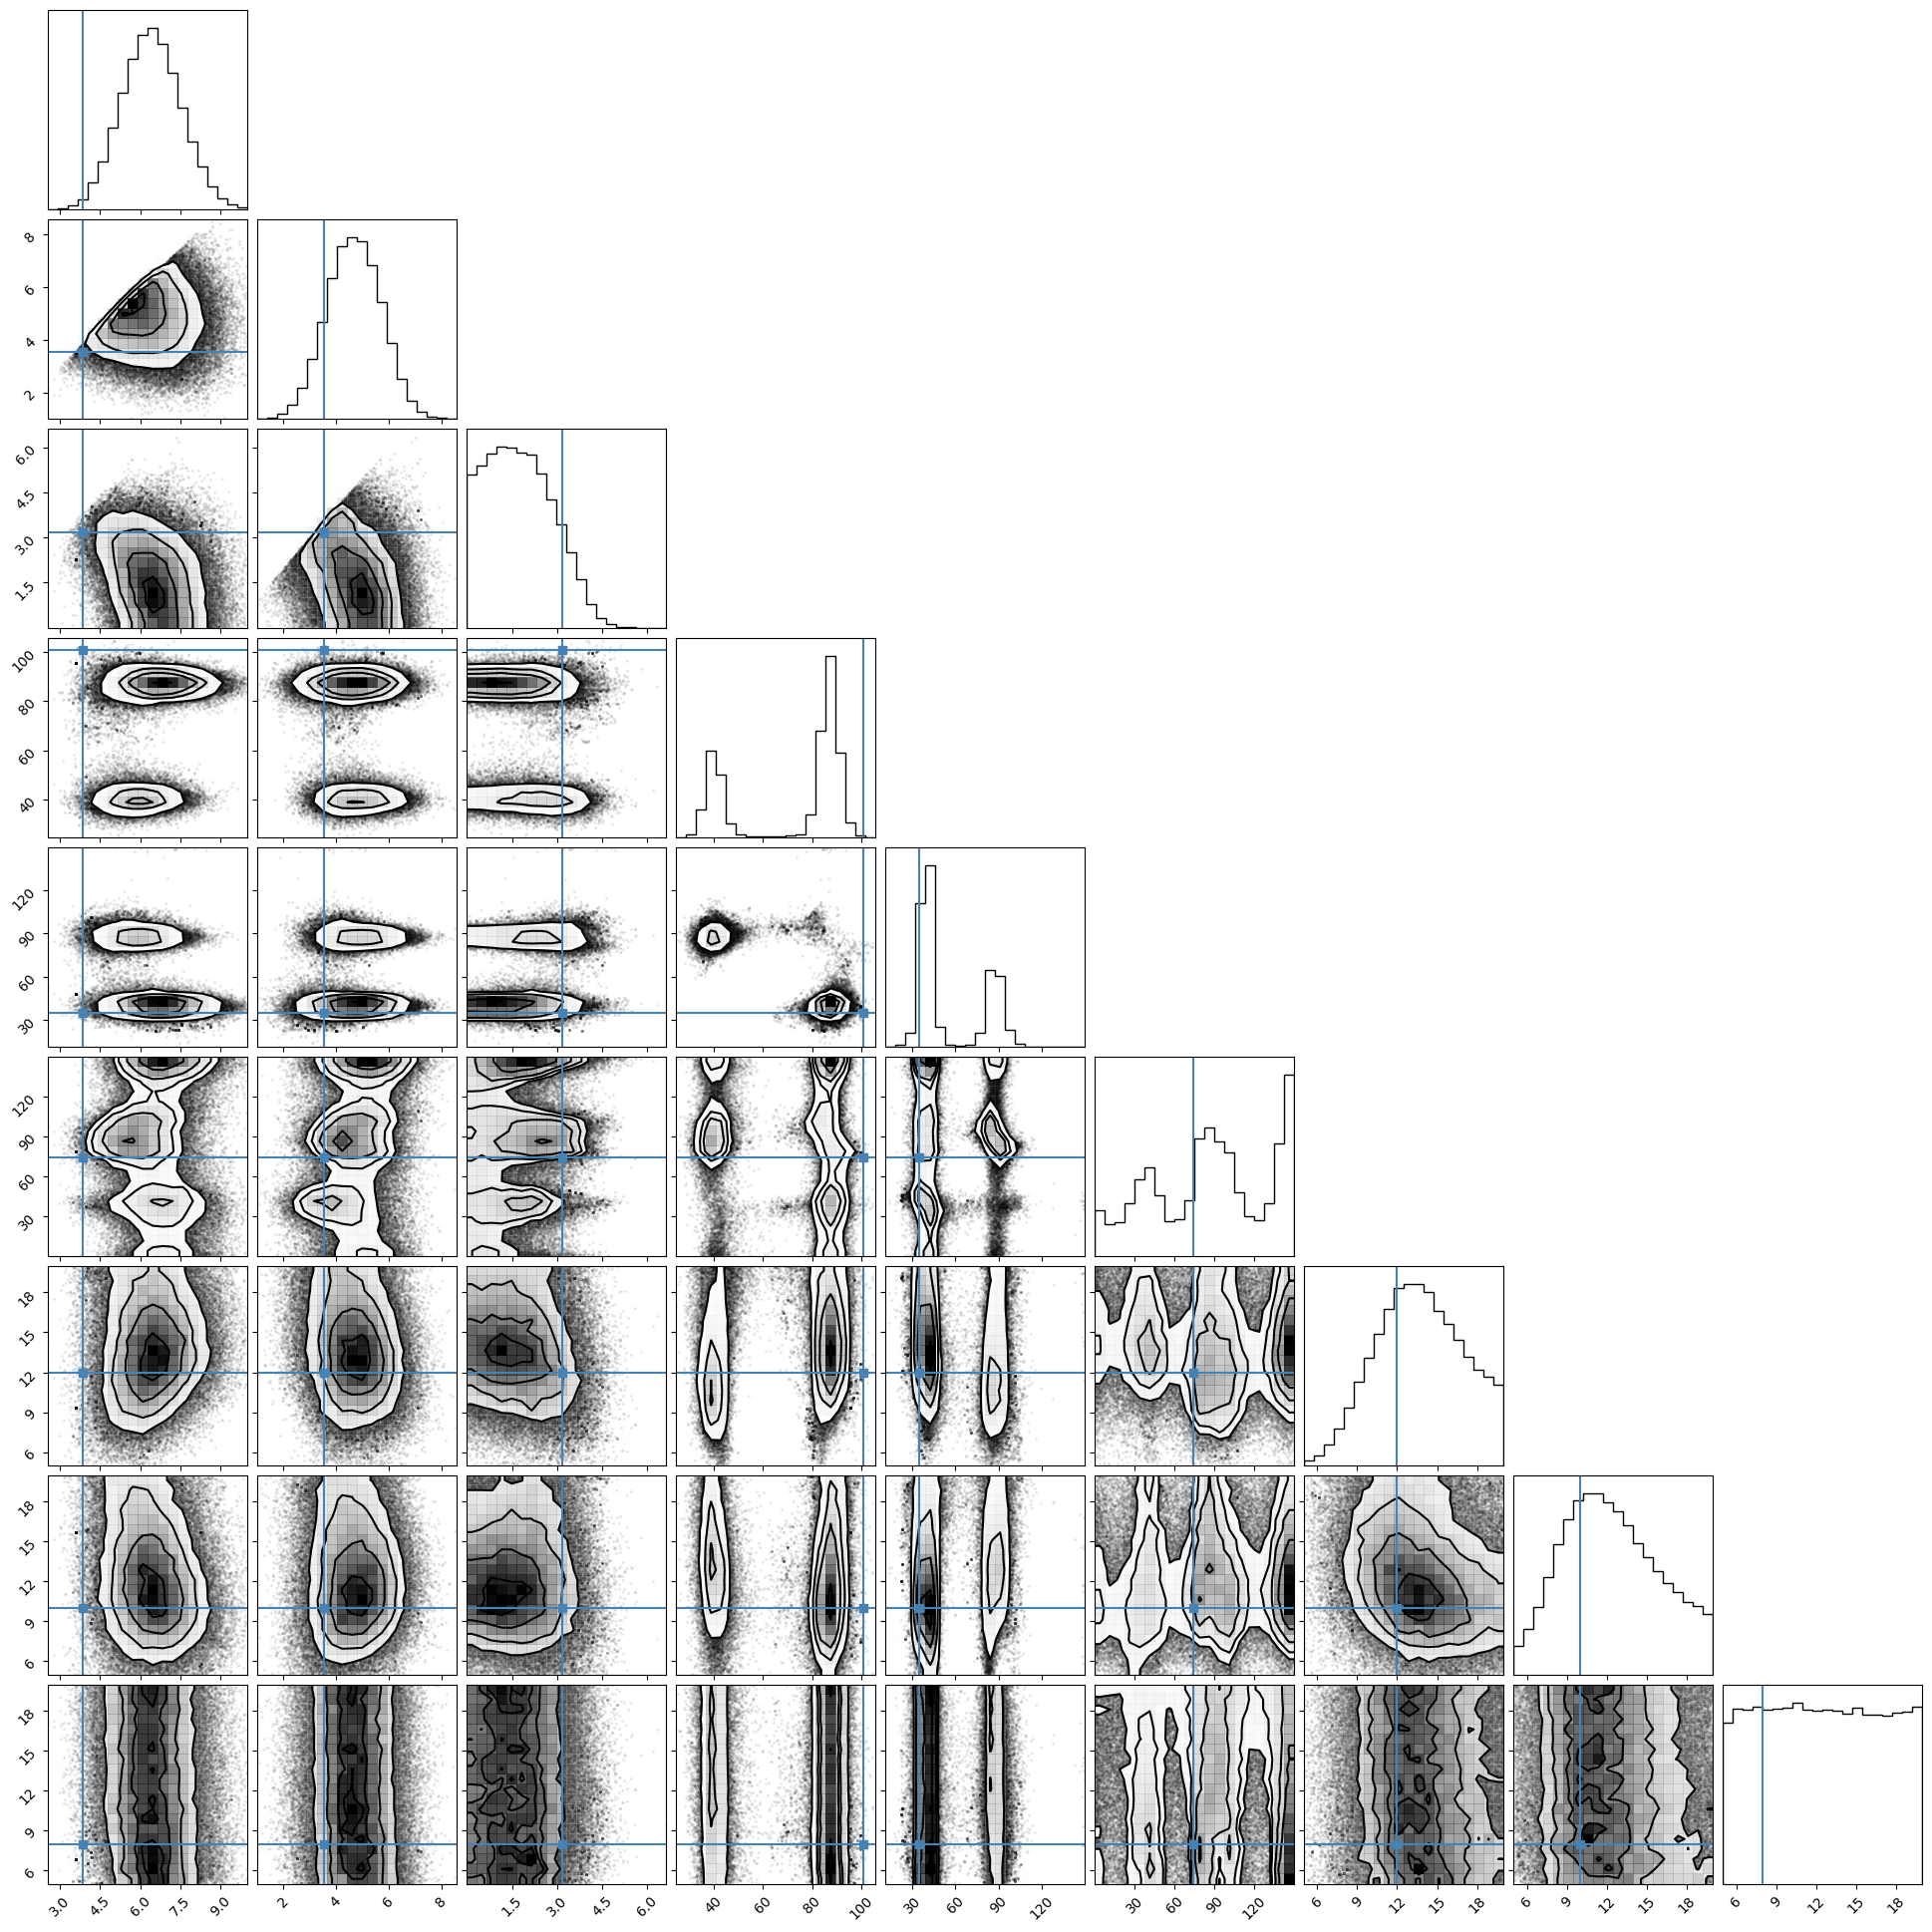

In [10]:
samples = jnp.concatenate([snrs, mm, ss], axis = -1)
corner(np.array(samples), truths = np.concatenate([snr, m, s]));

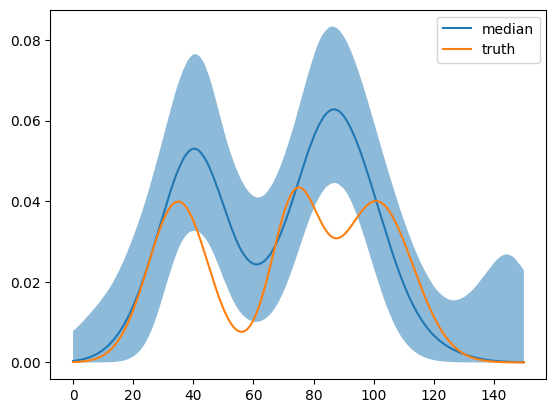

In [11]:
signals = signal_model(t[None, :], aa[:, None], mm[:, None], ss[:, None])
plt.fill_between(t, *np.quantile(signals, (0.05, 0.95), axis = 0), alpha = 0.5)
plt.plot(t, np.median(signals, axis = 0), label = 'median')
plt.plot(t, signal, label = 'truth')
plt.legend();

## transdimensional HMC

In [12]:
# Have to make sure the change of variables results in the correct
# prior density for the sampled number of parameters n <= n_max.
# The masking must also act on arrays with static shapes for JAX jitting
# and be autodifferentiable.
# Below is one way to achieve this.

def masked_order(x, n):
    k = x.size
    i = jnp.arange(k)
    p = jnp.where(i < n, 1 / (n - i), 0)
    y = jnp.power(1 - x, p)
    y = jnp.cumprod(y)
    y = jnp.where(i < n, y, 0)
    return y

True
[[-0.57595989  0.          0.          0.          0.          0.        ]
 [-0.11741812 -0.86811601  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]]


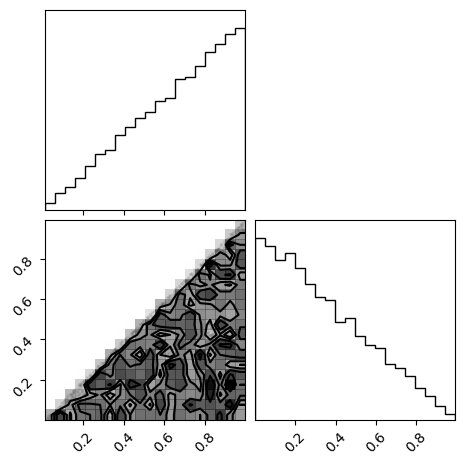

In [13]:
n = 2
n_max = 6

x = jax.random.uniform(jax.random.key(42), (10_000, n_max))
y = jax.vmap(lambda x: masked_order(x, n))(x)

# and that the n_max - n parameters (SNR "ghost parameters") are masked.
print(jnp.all(y[:, n:] == 0))

# Check that the masking is differentiable.
print(jax.jacfwd(masked_order)(x[0], n))

# Check that the density of the n <= n_max parameters is uniform
corner(np.array(y[:, :n]));

In [14]:
def model():
    n_max = 6

    with numpyro.plate('n_max', n_max):
        # snr = numpyro.sample('snr', numpyro.distributions.Uniform(0, 10))
        # snr = sample('snr', numpyro.distributions.Uniform(0, 10))
        _snr = numpyro.sample('_snr', numpyro.distributions.Uniform())
        # _snr = sample('_snr', numpyro.distributions.Uniform())
        
        m = numpyro.sample('m', numpyro.distributions.Uniform(0, 150))
        # m = sample('m', numpyro.distributions.Uniform(0, 150))
        # _m = numpyro.sample('_m', numpyro.distributions.Uniform())
        # _m = sample('_m', numpyro.distributions.Uniform())
        # m = numpyro.deterministic('m', order(_m) * 150)
        
        s = numpyro.sample('s', numpyro.distributions.Uniform(5, 20))
        # s = sample('s', numpyro.distributions.Uniform(5, 20))

    n = numpyro.sample('n', numpyro.distributions.DiscreteUniform(0, n_max))
    snr = numpyro.deterministic('snr', masked_order(_snr, n) * 10)

    a = numpyro.deterministic('a', snr_to_amplitude(snr, s, sn, t))
    signal = signal_model(t, a, m, s)
    noise = (data - signal) / sn
    with numpyro.plate('t', t.size):
        numpyro.sample('noise', numpyro.distributions.Normal(), obs = noise)

In [15]:
nuts = numpyro.infer.NUTS(model, dense_mass = False)
gibbs = numpyro.infer.DiscreteHMCGibbs(
    nuts, random_walk = False, modified = False,
)
mcmc = numpyro.infer.MCMC(
    gibbs,
    num_warmup = 1_000,
    num_samples = 1_000, 
    # thinning = 100,
    num_chains = 100,
    chain_method = jax.vmap,
    progress_bar = True,
)
mcmc.run(jax.random.key(2))
mcmc.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   _snr[0]      0.70      0.20      0.71      0.43      1.00    725.01      1.07
   _snr[1]      0.44      0.27      0.41      0.00      0.83   2188.40      1.03
   _snr[2]      0.60      0.28      0.64      0.17      1.00  13566.01      1.01
   _snr[3]      0.51      0.29      0.52      0.11      1.00  33494.31      1.00
   _snr[4]      0.50      0.29      0.51      0.10      1.00  37619.82      1.00
   _snr[5]      0.50      0.29      0.50      0.01      0.91  35616.87      1.00
      m[0]     77.18     19.67     86.05     38.31     93.34     57.84      3.61
      m[1]     50.96     20.79     41.32     32.89     90.70     62.63      2.82
      m[2]     81.59     43.36     83.75     22.76    150.00  10931.16      1.01
      m[3]     76.91     43.62     77.82     16.87    149.99  18759.85      1.01
      m[4]     75.06     43.44     75.47     14.36    149.58  28135.79      1.00
      m[5]     74.99     43

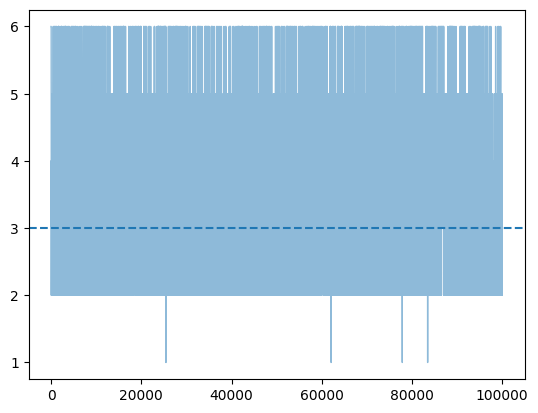

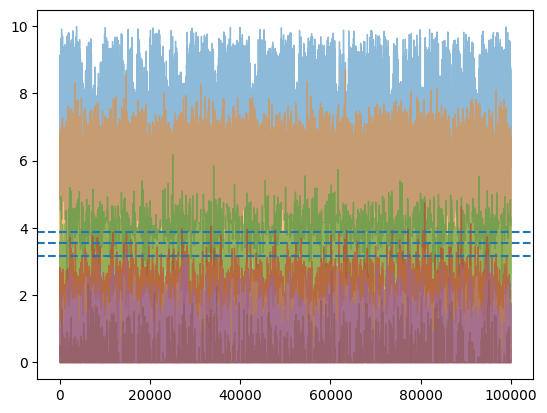

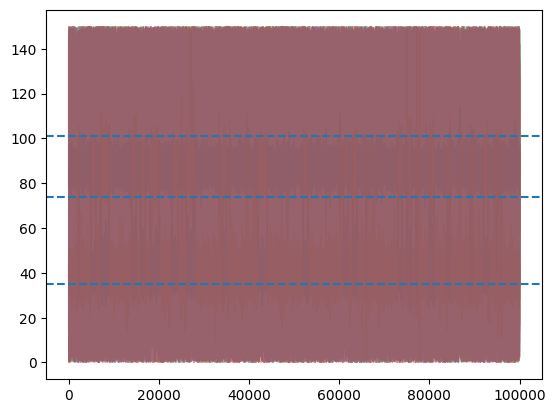

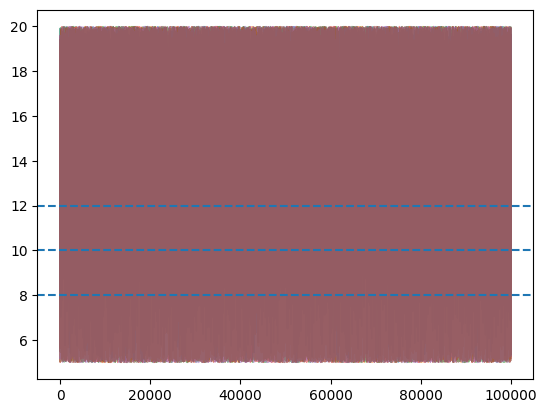

In [16]:
for k, truths in zip(('n', 'snr', 'm', 's'), ([3], snr, m, s)):
    chains = mcmc.get_samples()[k]
    plt.plot(chains, lw = 1, alpha = 0.5)
    for truth in truths:
        plt.axhline(truth, ls = '--')
    plt.show()

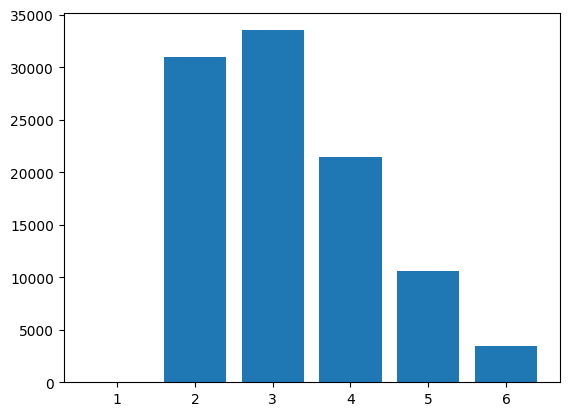

In [17]:
plt.bar(*np.unique(mcmc.get_samples()['n'], return_counts = True));

In [18]:
n = 3
ns = mcmc.get_samples()['n']
samples = jnp.stack([mcmc.get_samples()[k] for k in ('snr', 'a', 'm', 's')])
samples = samples[:, ns == n, :n]
snrs, aa, mm, ss = samples
samples = jnp.concatenate([snrs, mm, ss], axis = -1)
samples.shape, aa.shape

((33507, 9), (33507, 3))

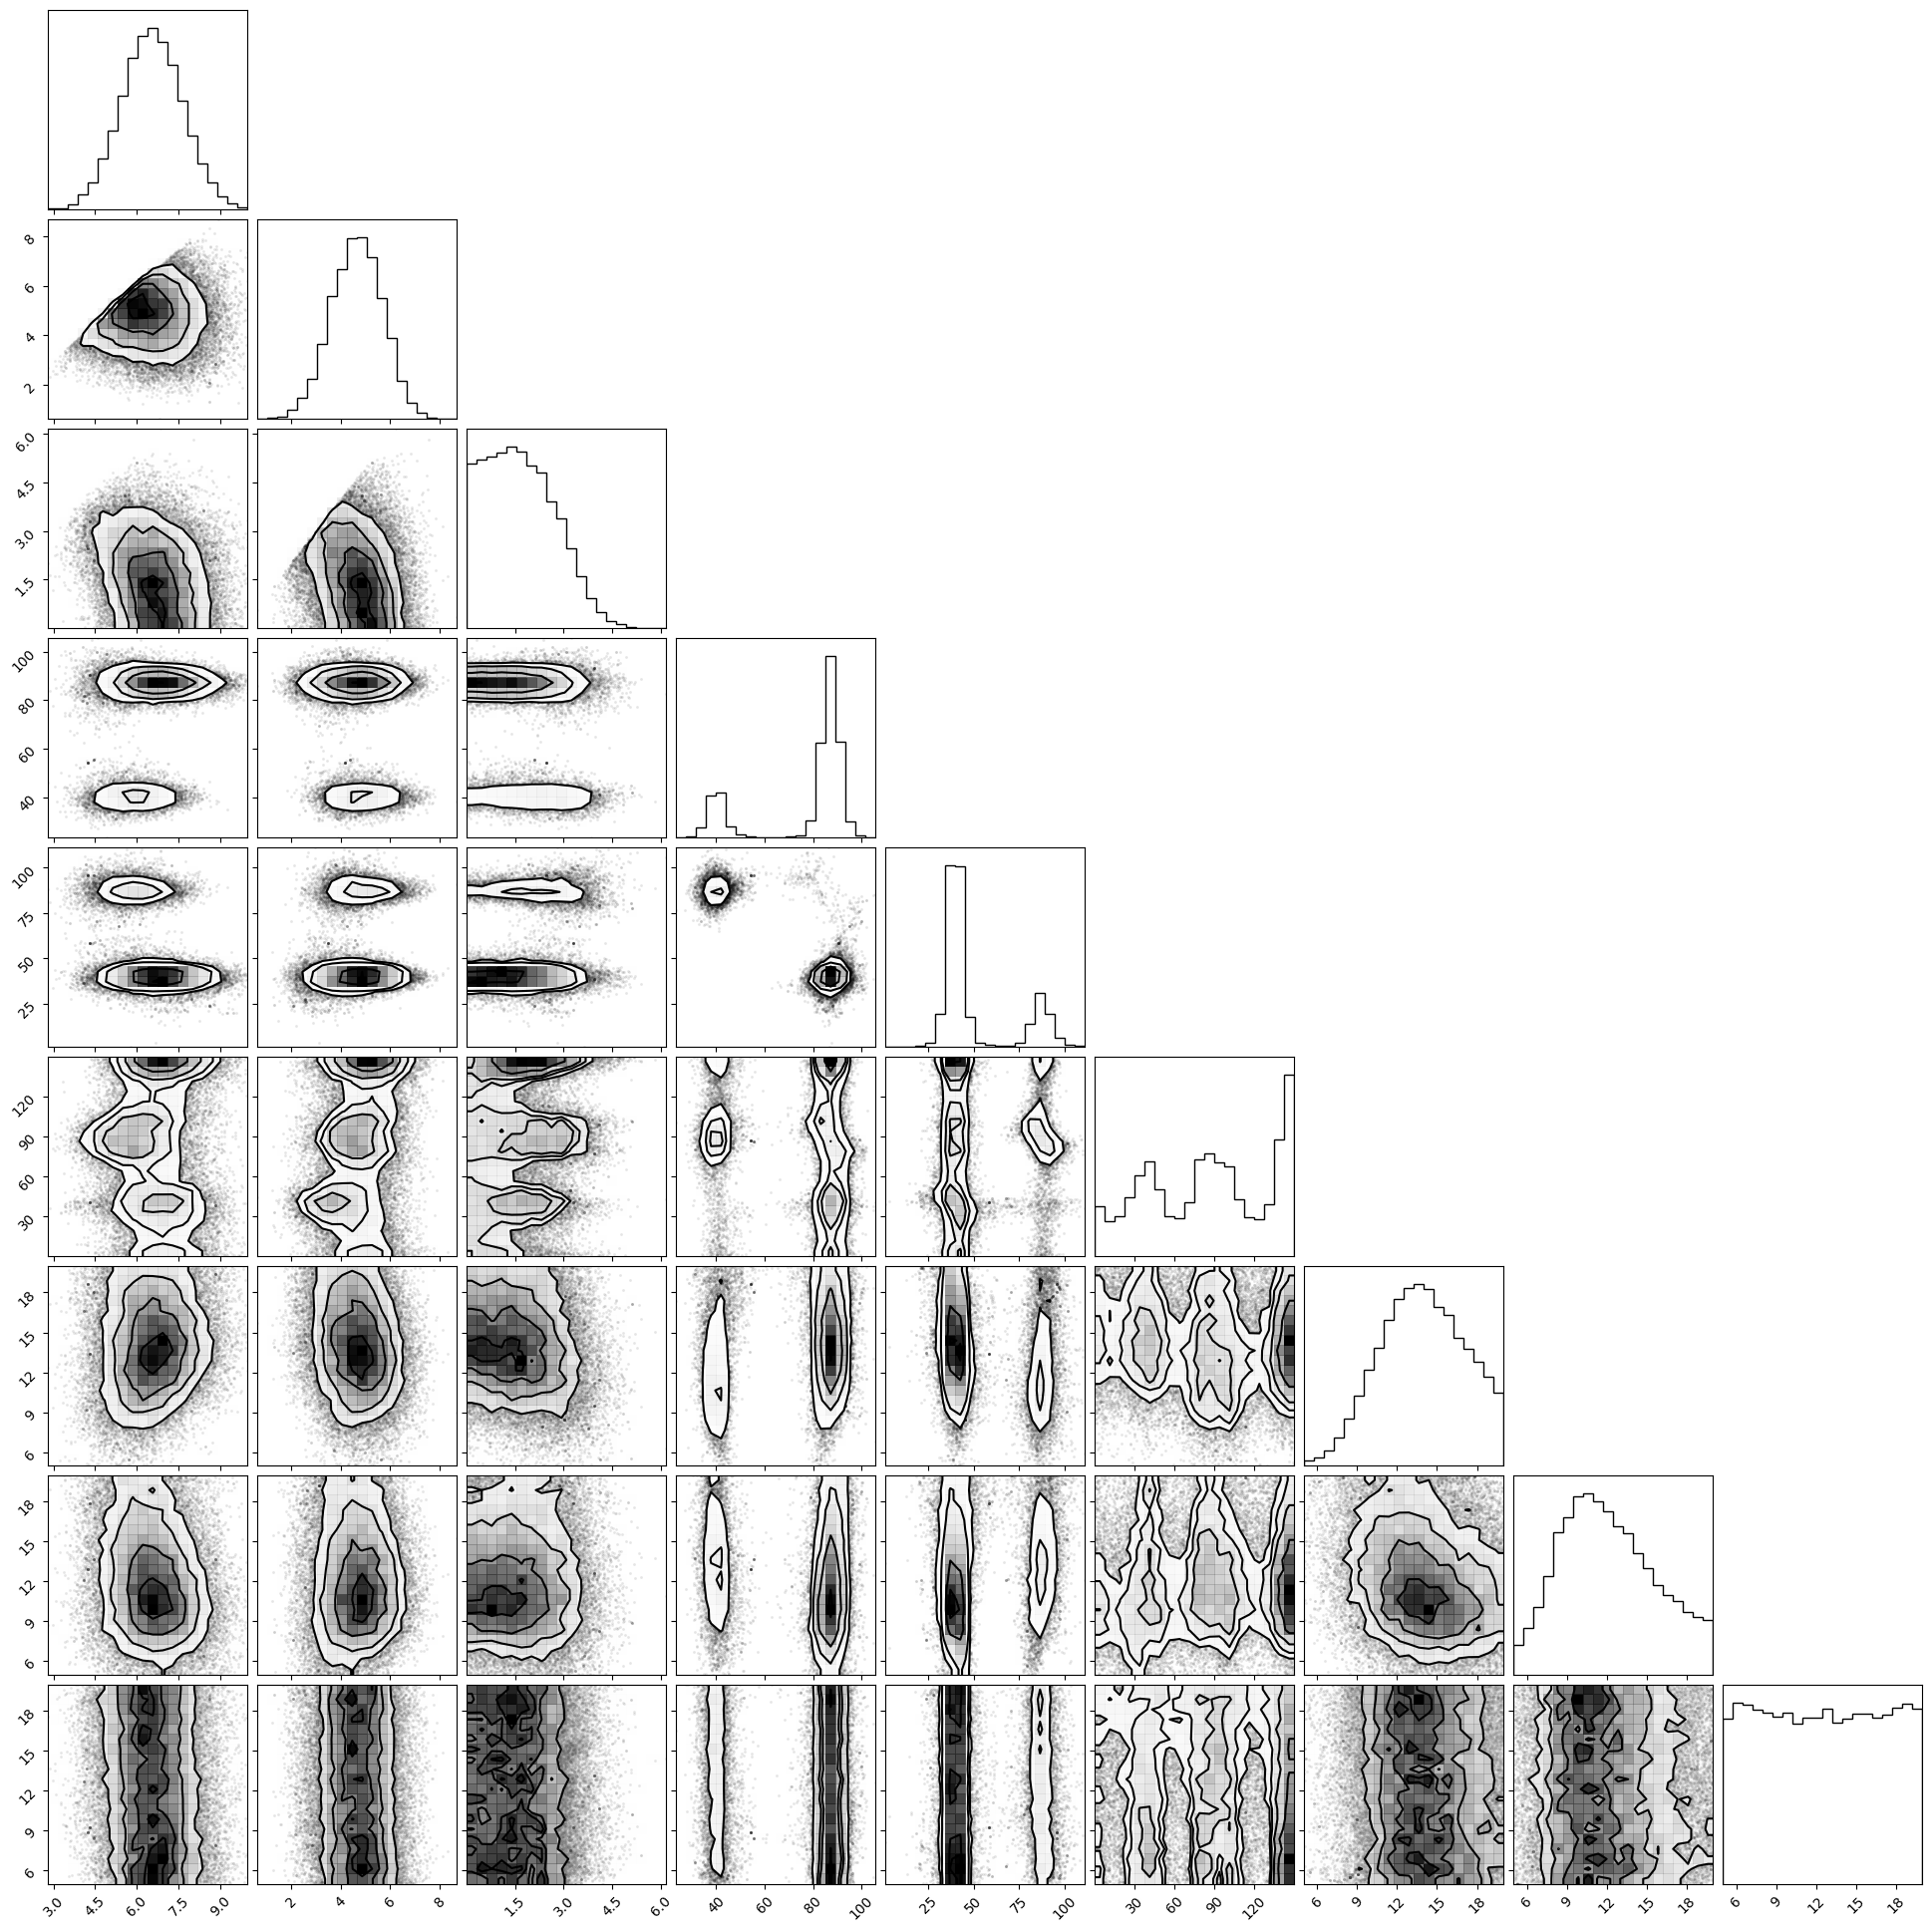

In [19]:
corner(
    np.array(samples),
    # truths = np.concatenate([snr, m, s]),
);

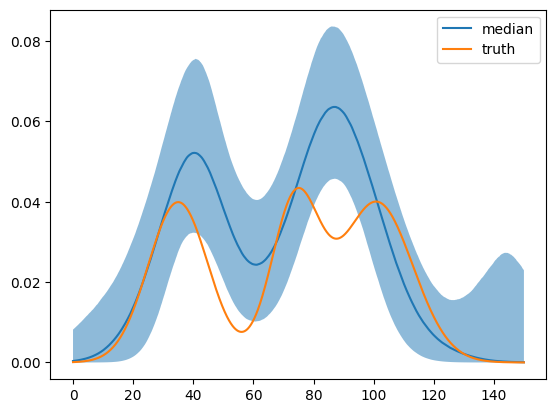

In [20]:
signals = signal_model(t[None, :], aa[:, None], mm[:, None], ss[:, None])
plt.fill_between(t, *np.quantile(signals, (0.05, 0.95), axis = 0), alpha = 0.5)
plt.plot(t, np.median(signals, axis = 0), label = 'median')
plt.plot(t, signal, label = 'truth')
plt.legend();